# Assignment3 - Heart Rate Analysis from video

---

## 1. Members
* 2017572006 SooYeon Lee
* 2017572012 YunSong Jeong

## 2. Environment
* OS X
* python 3.5
* iPhone X, iPhone8
* 1080(hd) 30Fps Video Camera

## 3. Requirement
* pip install sk-video
* brew install ffmpeg
* pip install pillow (PIL)


---

## 4. Code

### 1. Read the videos with Scikit-Video and Pillow/PIL library

In [101]:
# Read a given video file using Skvideo 
import skvideo.io          
import skvideo.datasets

video_path = "video/sy_1.mov"
videogen = skvideo.io.vread(video_path)
print ("Shape :",videogen.shape) #Shape of video. Frame num, width, height, RGB

Shape : (1220, 1920, 1080, 3)


In [2]:
# Metadata for the video

# 30fps, about 30s video
import json
metadata= skvideo.io.ffprobe(video_path)
print(metadata.keys())
print(json.dumps(metadata["video"], indent=4))

(1220, 1920, 1080, 3)
dict_keys(['video', 'audio', 'data'])
{
    "@index": "1",
    "@codec_name": "h264",
    "@codec_long_name": "H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10",
    "@profile": "High",
    "@codec_type": "video",
    "@codec_time_base": "4879/292800",
    "@codec_tag_string": "avc1",
    "@codec_tag": "0x31637661",
    "@width": "1080",
    "@height": "1920",
    "@coded_width": "1080",
    "@coded_height": "1920",
    "@has_b_frames": "0",
    "@sample_aspect_ratio": "1:1",
    "@display_aspect_ratio": "9:16",
    "@pix_fmt": "yuv420p",
    "@level": "40",
    "@color_range": "tv",
    "@color_space": "bt709",
    "@color_transfer": "bt709",
    "@color_primaries": "bt709",
    "@chroma_location": "left",
    "@refs": "1",
    "@is_avc": "true",
    "@nal_length_size": "4",
    "@r_frame_rate": "30/1",
    "@avg_frame_rate": "146400/4879",
    "@time_base": "1/600",
    "@start_pts": "0",
    "@start_time": "0.000000",
    "@duration_ts": "24395",
    "@duration": "40.

### 2. Average all pixels per frame
* Visualize value across time
* For Red channel and Luminance

In [3]:
import numpy as np
from PIL import Image

#Initialize
converted_avg_arr = []
frame_avg_arr = []
for frame in videogen:
    # Get Luminance channel for each frame
    fimage = Image.fromarray(frame, 'RGB')
    converted_image = fimage.convert("L")
    
    # Get Luminance average for each frame and append to list
    converted_avg = np.mean(np.array(converted_image), axis=(0,1))
    converted_avg_arr.append(converted_avg)
    
    # Get RGB average for each frame and append to list
    frame_avg = np.mean(frame, axis=(0,1))
    frame_avg_arr.append(frame_avg)


Original Frame image


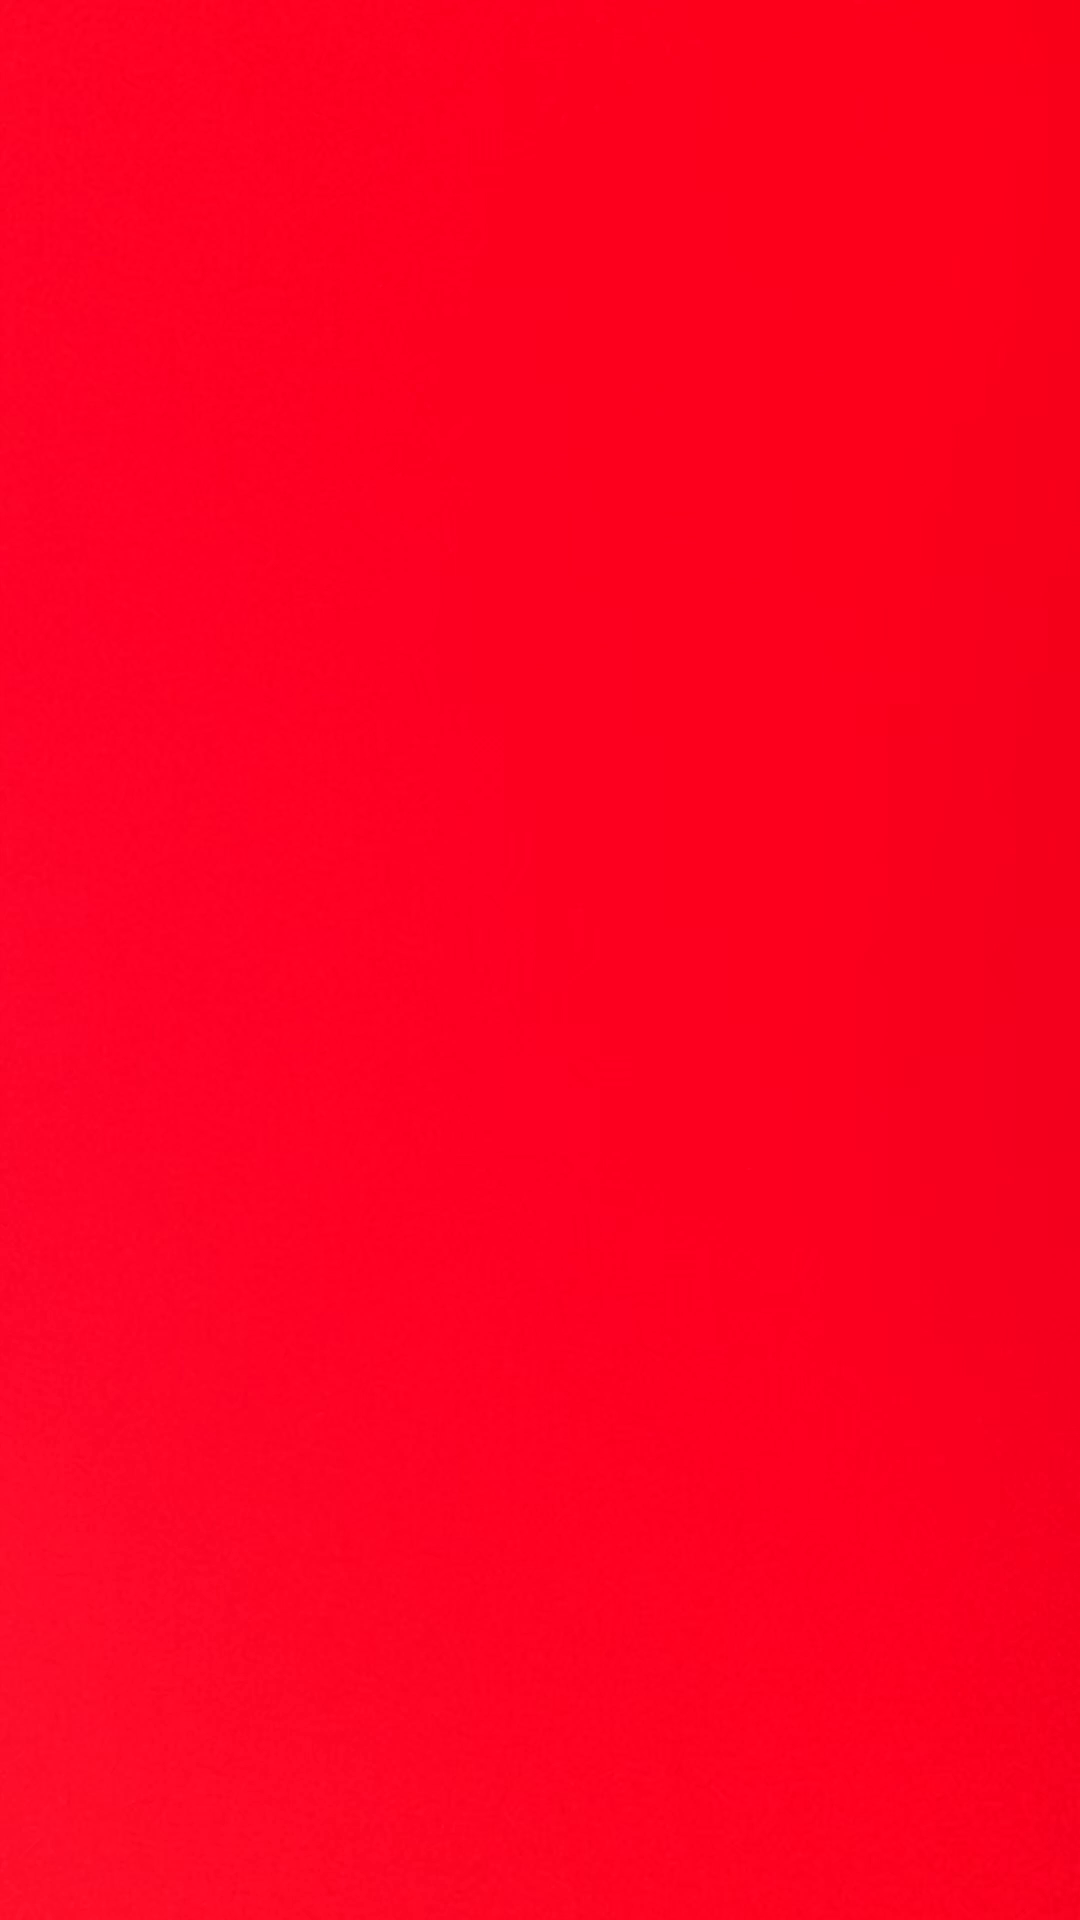

In [8]:
print ("Original Frame image")
fimage

Luminance channel Frame Image


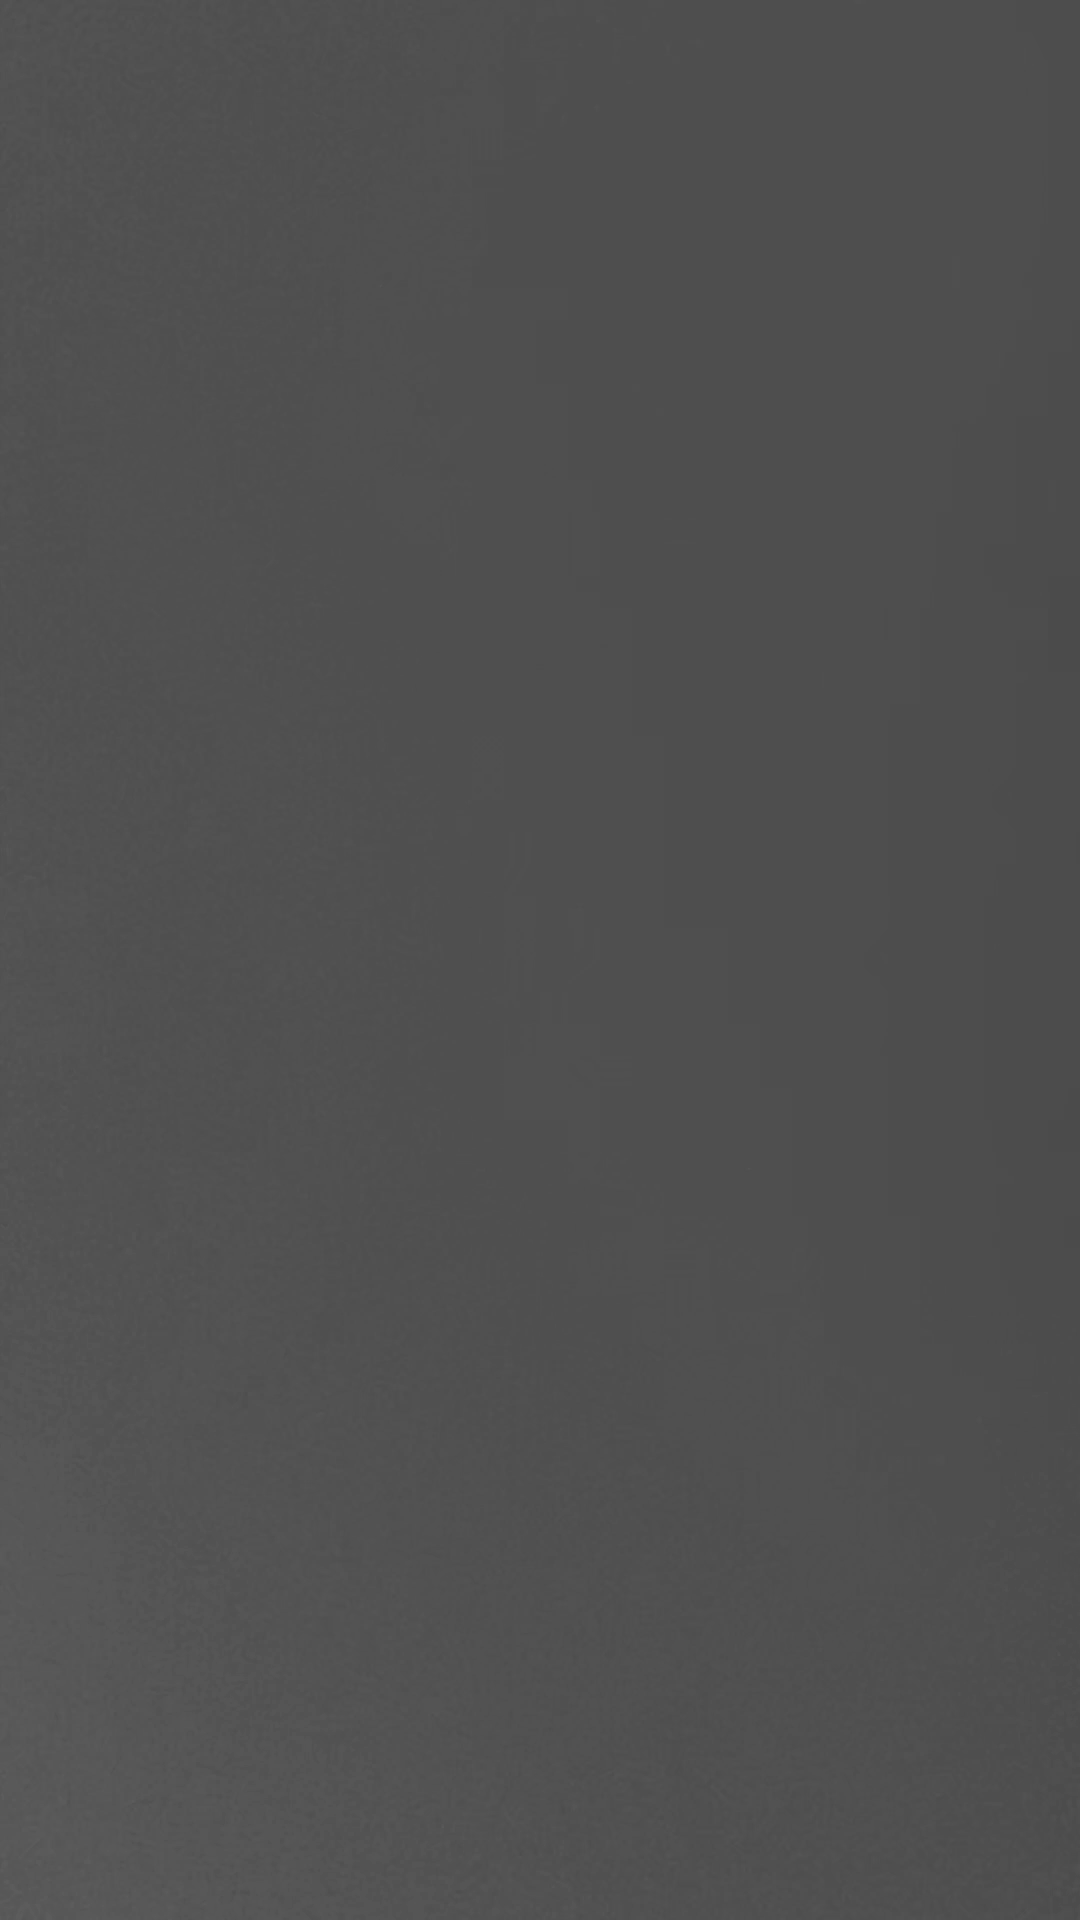

In [10]:
# No RGB, just Luminance(one element)
print ("Luminance channel Frame Image")
converted_image

In [13]:
# Get only Red Channel Average
frame_avg_arr = np.array(frame_avg_arr)
red_channel_avg = frame_avg_arr[:,0] # It is RGB, so just get the first one

# Get Luminance channel Average
converted_avg_arr = np.array(converted_avg_arr) # Only one element here

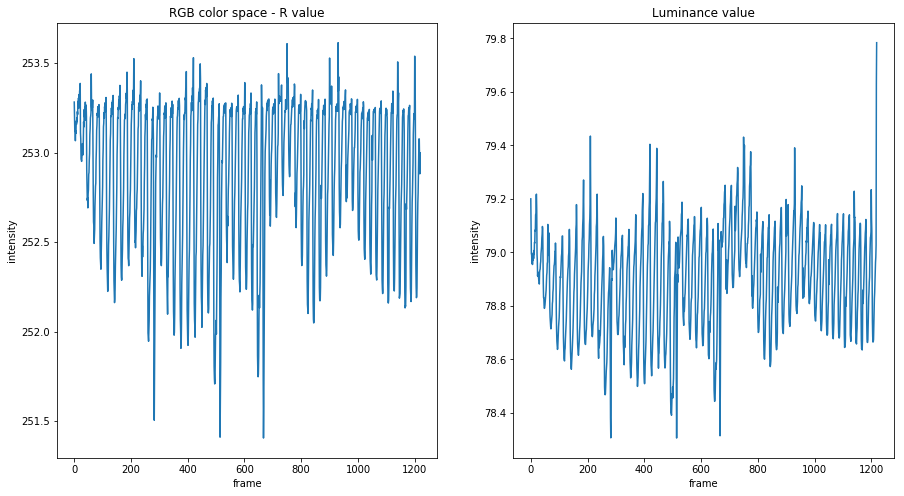

In [15]:
## Plot each value per frame
import matplotlib as mpl
import matplotlib.pylab as plt
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(red_channel_avg)
plt.title('RGB color space - R value')
plt.xlabel("frame")
plt.ylabel("intensity")
plt.subplot(122)
plt.plot(converted_avg_arr)
plt.title("Luminance value")
plt.xlabel("frame")
plt.ylabel("intensity")
plt.show()

### 3. Filter the Signal
* Remove slow drift and higher-frequency noise (removing DC component - finger movement or changes in venous pressure, etc.)
* fourth-rder Butterworth band-pass filter
* Filtering Range : 40~200 per minutes

In [18]:
BPM_L = 40;    # Heart rate lower limit [bpm]
BPM_H = 200;   # Heart rate higher limit [bpm]
FrameRate = 30 # Video Frame rate is 30fps
 
# Butterworth frequencies must be in [0, 1], where 1 corresponds to half the sampling rate (15 per 1 seconds)

from scipy.signal import butter, lfilter

def butter_bandpass_filter(data):
    # nyq = 0.5 * fs #Nyquist frequeny is half the sampling frequency
    # low = lowcut / nyq
    # high = highcut / nyq
    
    # To get the last 900 frame of video (for 30fps, it is 30seconds)
    # We did it because we thought that the first few frames could have a little bit ambiguous value.
    to_900_frame = len(data) - 900
    low =  (BPM_L / 60) / FrameRate * 2
    high = (BPM_H / 60) / FrameRate * 2
    b, a = butter(4, [low, high], btype='band')
    y = lfilter(b, a, data)
    y = y[to_900_frame:]
    return y

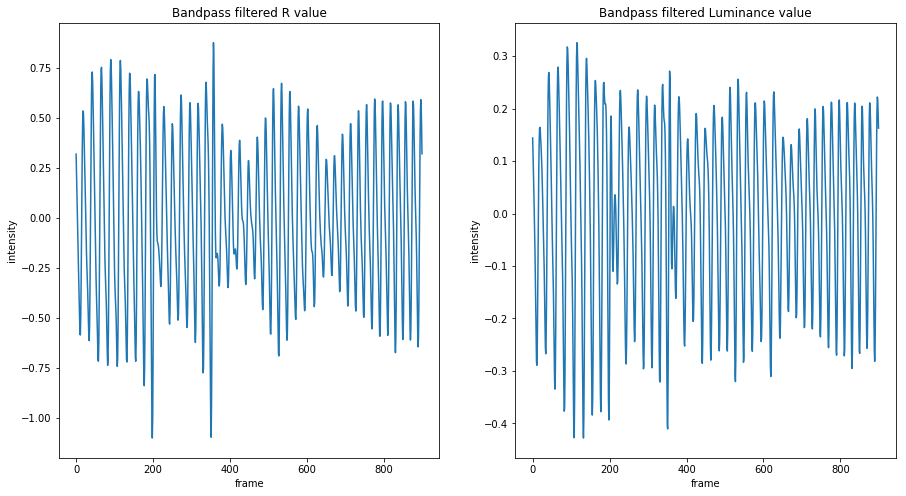

In [19]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
y1 = butter_bandpass_filter(red_channel_avg)
plt.plot(y1)
plt.title('Bandpass filtered R value')
plt.xlabel("frame")
plt.ylabel("intensity")

plt.subplot(122)
y2 = butter_bandpass_filter(converted_avg_arr)
plt.plot(y2)
plt.title("Bandpass filtered Luminance value")
plt.xlabel("frame")
plt.ylabel("intensity")
plt.show()

Merge as one module

In [78]:

def band_filter_videoLR(frames):
    #Initialize
    converted_avg_arr = []
    frame_avg_arr = []
    for frame in frames:
        # Get Luminance channel
        fimage = Image.fromarray(frame, 'RGB')
        converted_image = fimage.convert("L")

        # Get Luminance average for each frame
        converted_avg = np.mean(np.array(converted_image), axis=(0,1))
        converted_avg_arr.append(converted_avg)

        # Get RGB average for each frame
        frame_avg = np.mean(frame, axis=(0,1))
        frame_avg_arr.append(frame_avg)
        
    # Get only Red Channel Average
    frame_avg_arr = np.array(frame_avg_arr)
    red_channel_avg = frame_avg_arr[:,0] # It is RGB, so just get the first one

    # Get Luminance channel Average
    converted_avg_arr = np.array(converted_avg_arr) # Only one element here
    
    BPM_L = 40;    # Heart rate lower limit [bpm]
    BPM_H = 200;   # Heart rate higher limit [bpm]
    FrameRate = 30 # Video Frame rate is 30fps
    
    #Band-pass filter
    filtered_r = butter_bandpass_filter(red_channel_avg)
    filtered_l = butter_bandpass_filter(converted_avg_arr)
    
    return filtered_r, filtered_l


* Five sample moving average filter

/Users/ahroobe/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
/Users/ahroobe/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


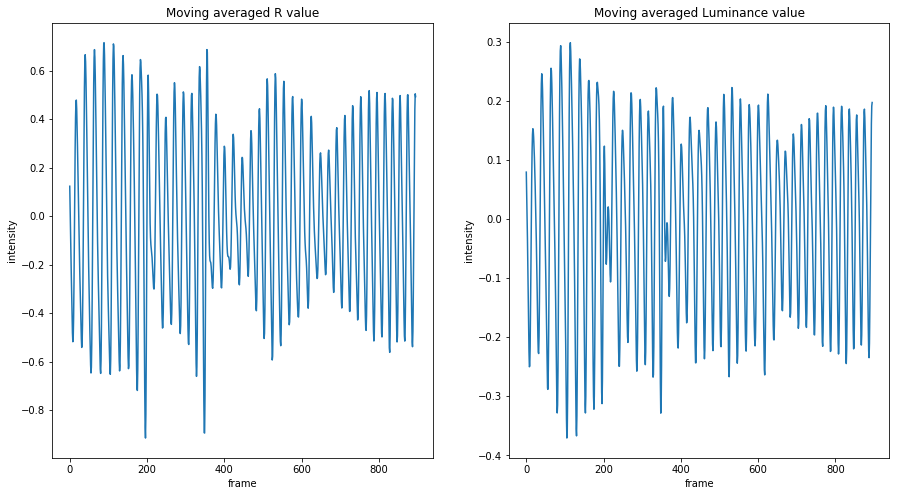

In [20]:
import pandas as pd
# Five-sample moving average. (drop first 4 elements : NaN)
moving_average_r = pd.rolling_mean(y1, 5)[4:]
moving_average_l = pd.rolling_mean(y2, 5)[4:]

#Plot
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)

plt.plot(moving_average_r)
plt.title('Moving averaged R value')
plt.xlabel("frame")
plt.ylabel("intensity")


plt.subplot(122)
plt.plot(moving_average_l)
plt.title("Moving averaged Luminance value")
plt.xlabel("frame")
plt.ylabel("intensity")
plt.show()

### 4. Upsample and Interpolate Data
* 30 HZ -> 180 HZ
* Cubic spline interpolation


* without s=.1, inteporlate value becomes strange (We don't know actual reason..)
https://stackoverflow.com/questions/32501347/how-to-apply-cubic-spline-interpolation-over-long-pandas-series

In [23]:
from scipy.interpolate import splrep, spleval, splev

# convert to time series to Resample data from 60 hz to 180 hz
# 60s(min) to 10seconds (x6 upsample)
rng_r = pd.date_range('1/1/2018', periods=len(moving_average_r), freq='min')
ts_r = pd.Series(moving_average_r, index=rng_r)
upsampled_r = ts_r.resample('10s')
# Cubic spline
interpolate_r = upsampled_r.interpolate(method = 'spline', order= '3', s=.0)
rng_l = pd.date_range('1/1/2018', periods=len(moving_average_l), freq='min')
ts_l = pd.Series(moving_average_l, index=rng_l)
upsampled_l = ts_l.resample('10s')
interpolate_l = upsampled_l.interpolate(method = 'spline', order= '3', s=.0)

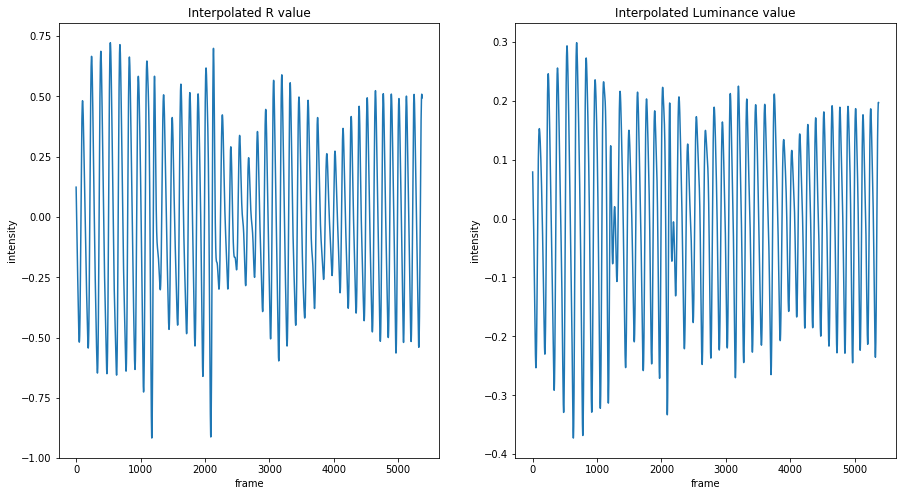

In [29]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)

# Get rid of datetime axis (use np.array)
plt.plot(np.array(interpolate_r))
plt.title('Interpolated R value')
plt.xlabel("frame")
plt.ylabel("intensity")

plt.subplot(122)
plt.plot(np.array(interpolate_l))
plt.title("Interpolated Luminance value")
plt.xlabel("frame")
plt.ylabel("intensity")
plt.show()

In [26]:
# Make it to array (get only values without datetime)
interpolate_l = np.array(interpolate_l)
interpolate_r = np.array(interpolate_r)

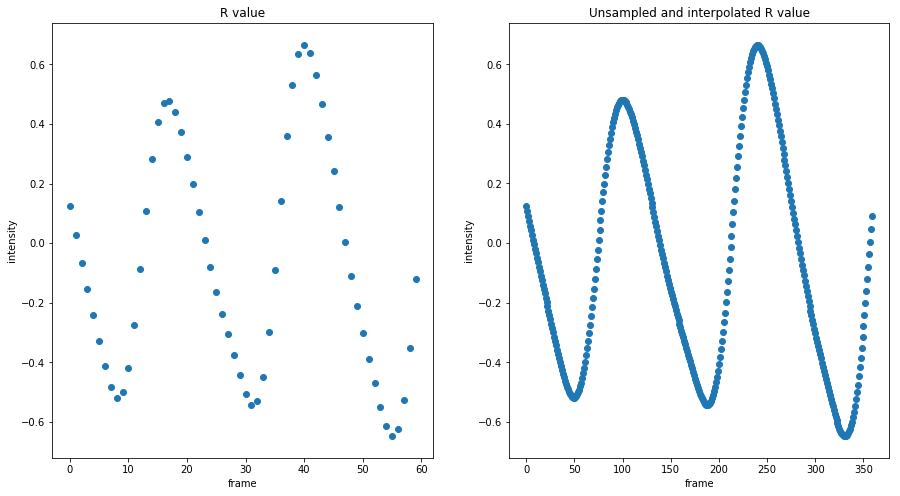

In [123]:
# Plot for the first 2 secons before and after unsampling and interpolation
first2sR_before = moving_average_r[:60] # 30Hz - 2s
first2sR_after = interpolate_r[:360] # 180Hz - 2s
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.scatter(range(0,len(first2sR_before)),first2sR_before)
plt.title('R value')
plt.xlabel("frame")
plt.ylabel("intensity")

#denser (x6)
plt.subplot(122)
plt.scatter(range(0,len(first2sR_after)),first2sR_after)
plt.title("Unsampled and interpolated R value")
plt.xlabel("frame")
plt.ylabel("intensity")
plt.show()

### 5. Peak detection of R-peak
* peak detection -> how to choose width
    * widths : sequence 1-D array of widths to use for calculating the CWT matrix. In general, this range should cover the expected width of peaks of interest.
    * We used range(1,100) for 180Hz, range(1,18) for 30Hz
        * Brute-forcely found
    
    
#### 1) Interpolate_r (180Hz, upsampled->Interpolated)

81


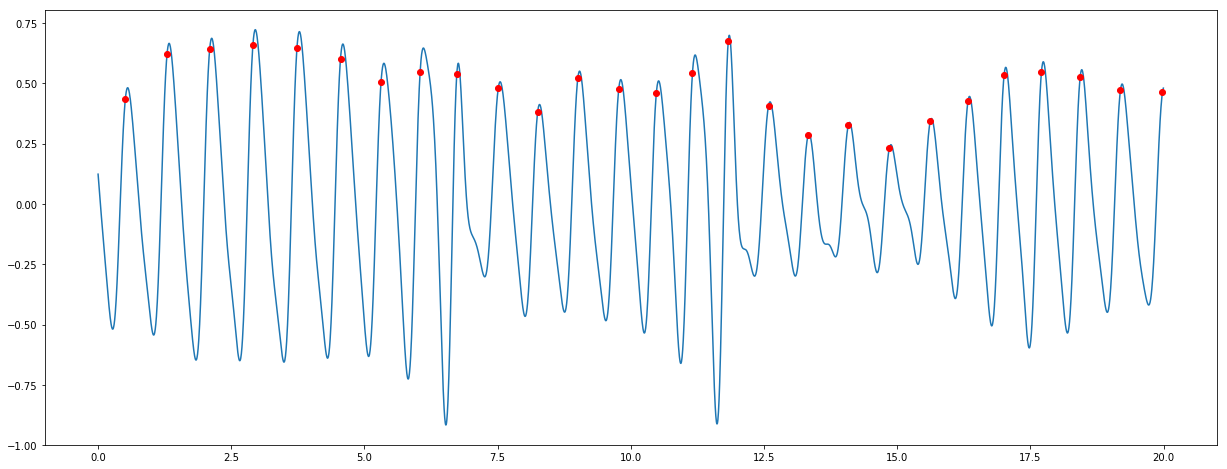

In [66]:
from scipy import signal

fs = 180 # upsampled Hz

# time vector (first 20s)
t = np.arange(0,20,1/fs)

fig = plt.figure(figsize=(21, 8))

#width : np.arange(1,100) : [1,2,...,100]
# Used len(t) to cut off first 20 seconds from data
peakind = signal.find_peaks_cwt(interpolate_r[:len(t)], np.arange(1,100))

plt.plot(t, interpolate_r[:len(t)])
plt.plot(t[peakind],interpolate_r[peakind],'ro')

heart_beat = (len(peakind)*3)
print (heart_beat)

#### 2) Interpolated luminance

81


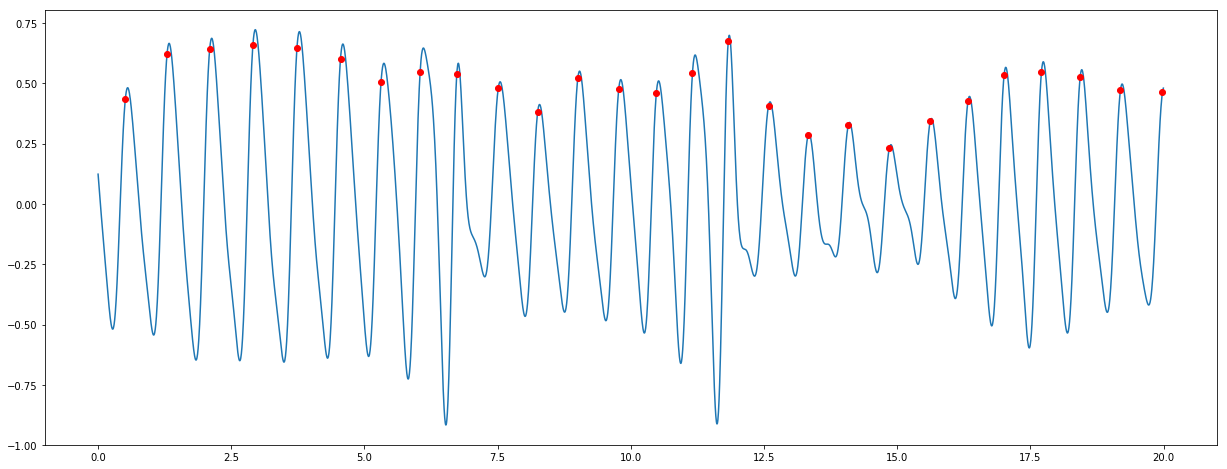

In [64]:
from scipy import signal
fs = 180

# time vector (first 20s)
t = np.arange(0,20,1/fs)

fig = plt.figure(figsize=(21, 8))
peakind = signal.find_peaks_cwt(interpolate_l[:len(t)], np.arange(1,100))
plt.plot(t, interpolate_l[:len(t)])
plt.plot(t[peakind],interpolate_l[peakind],'ro')

heart_beat = (len(peakind)*3)
print (heart_beat)

#### 3) Moving average(Before unsampled, 30Hz) Red

78


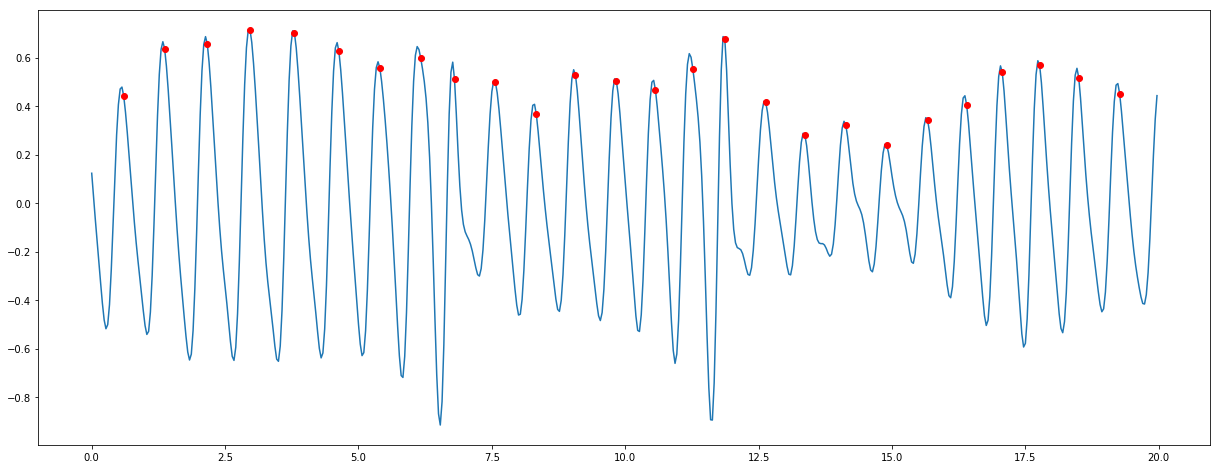

In [67]:
from scipy import signal

# sample rate
fs = 30.0

# time vector (first 20s)
t = np.arange(0,20,1/fs)

fig = plt.figure(figsize=(21, 8))
peakind = signal.find_peaks_cwt(moving_average_r[:len(t)], np.arange(1,18))
plt.plot(t, moving_average_r[:len(t)])
plt.plot(t[peakind],moving_average_r[peakind],'ro')

heart_beat = (len(peakind)*3)
print (heart_beat)

#### 4) Moving Average Luminance (30Hz)
could't catch some peaks

75


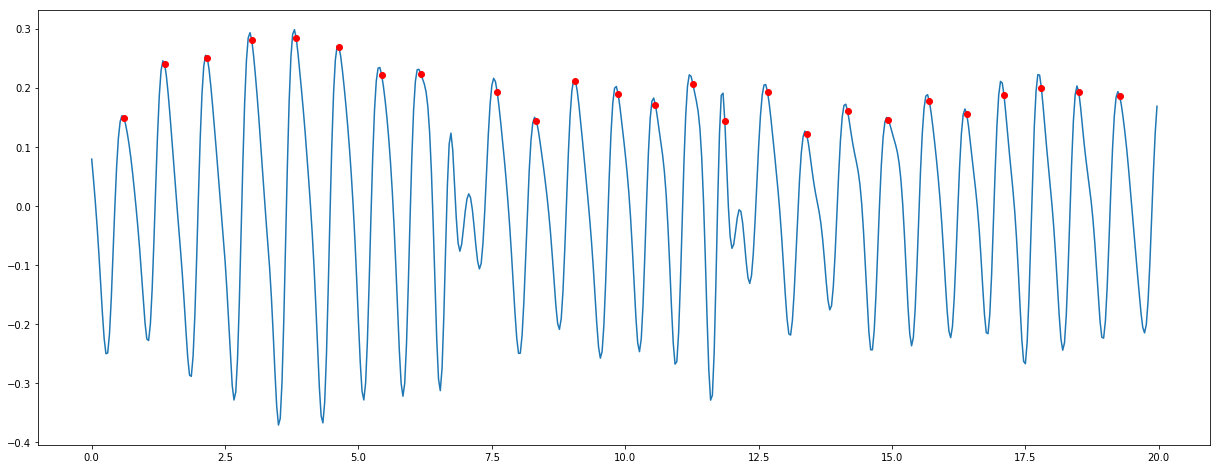

In [75]:
from scipy import signal

# sample rate(180Hz)
fs = 30.0

# time vector (first 20s)
t = np.arange(0,20,1/fs)

fig = plt.figure(figsize=(21, 8))
peakind = signal.find_peaks_cwt(moving_average_l[:len(t)], np.arange(1,18))
plt.plot(t, moving_average_l[:len(t)])
plt.plot(t[peakind],moving_average_l[peakind],'ro')

heart_beat = (len(peakind)*3)
print (heart_beat)

#### 5) Non-moving-averaged
* Without interolation, There are NAN values so plotting is impossible
* Here We plot non-moving-averaged data

78


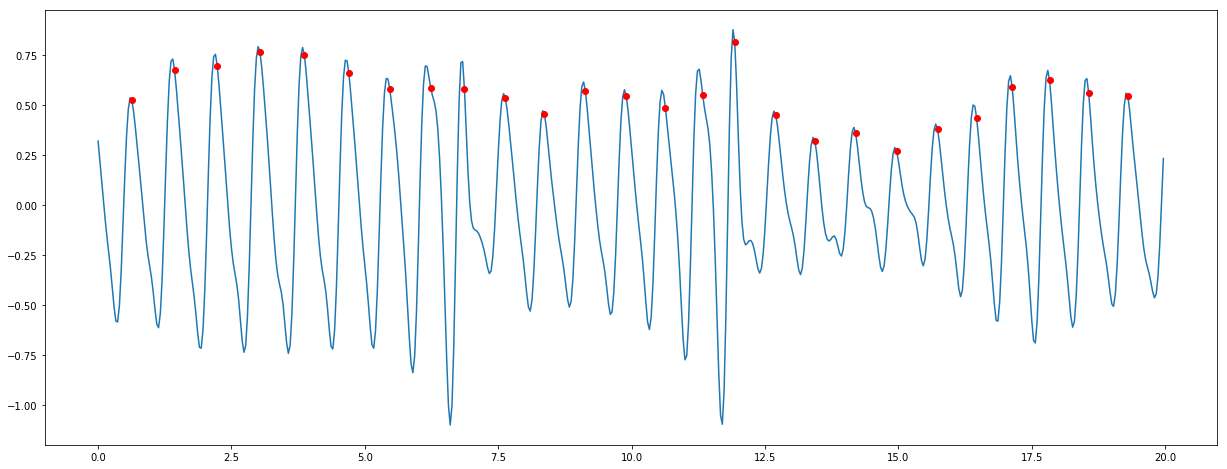

In [74]:

# sample rate(180Hz)
fs = 30

# time vector (first 20s)
t = np.arange(0,20,1/fs)

fig = plt.figure(figsize=(21, 8))
peakind = signal.find_peaks_cwt(y1[:len(t)], np.arange(1,18))
plt.plot(t, y1[:len(t)])
plt.plot(t[peakind],y1[peakind],'ro')

heart_beat = (len(peakind)*3)
print (heart_beat)


#### Merge

In [87]:
def getpeak_bps(data,fs):
    # time vector (first 20s)
    t = np.arange(0,20,1/fs)
    if fs == 30:
        rates = np.arange(1,18)
    else:
        rates = np.arange(1,100)
        
    peakind = signal.find_peaks_cwt(data[:len(t)], rates)
    heart_beat = (len(peakind)*3)
    
    return t, peakind, heart_beat

### Coment

The number of peaks looks similar(75,78,81) and also, actual positions of peaks are slightly different each other.

Interpolated Red color is the most accurate one.

---

### 7. Merge Function

In [94]:
def calBps(video_path):
    print ("%s is being handled"%video_path)
    videogen = skvideo.io.vread(video_path)
    # Print Frame shape, Resolution(1920x1080)
    print("Video Load done. Frame shape : %s", videogen.shape)

    filtered_l, filtered_r = band_filter_videoLR(videogen)
    print ("Filtering Done")
    
    # Moving Average (5)
    moving_average_r = pd.rolling_mean(filtered_l, 5)[4:]
    moving_average_l = pd.rolling_mean(filtered_r, 5)[4:]

    # convert to time series to Resample data from 60 hz to 180 hz
    # 60s(min) to 10seconds
    # R
    rng_r = pd.date_range('1/1/2018', periods=len(moving_average_r), freq='min')
    ts_r = pd.Series(moving_average_r, index=rng_r)
    upsampled_r = ts_r.resample('10s')
    interpolate_r = np.array(upsampled_r.interpolate(method = 'spline', order= '3', s=.0))
    # L
    rng_l = pd.date_range('1/1/2018', periods=len(moving_average_l), freq='min')
    ts_l = pd.Series(moving_average_l, index=rng_l)
    upsampled_l = ts_l.resample('10s')
    interpolate_l = np.array(upsampled_l.interpolate(method = 'spline', order= '3', s=.0))

    # Unsampled
    t1, peak1, heart_beat = getpeak_bps(moving_average_r,30)
    print ("Before (R) : %s", heart_beat)

    # L
    t2, peak2, heart_beat = getpeak_bps(moving_average_l,30)
    print ("Before (L) : %s", heart_beat)

    ##-----##
    # After Unsample+interpolate(R)
    t3, peak3, heart_beat = getpeak_bps(interpolate_r,180)
    print ("After (R) : %s", heart_beat)

    # After Unsample+interpolate(L)
    t4, peak4, heart_beat = getpeak_bps(interpolate_l,180)
    print ("After (L) : %s", heart_beat)
    
    """
    Plotting~
    
    """
    fig = plt.figure(figsize=(21, 6))
    plt.subplot(221)
    plt.plot(t1, moving_average_r[:len(t1)])
    plt.plot(t1[peak1],moving_average_r[peak1],'ro')
    plt.title('Before R value')

    plt.subplot(222)
    plt.plot(t2, moving_average_l[:len(t2)])
    plt.plot(t2[peak2],moving_average_l[peak2],'ro')
    plt.title('Before L value')

    plt.subplot(223)
    plt.plot(t3, interpolate_r[:len(t3)])
    plt.plot(t3[peak3],interpolate_r[peak3],'ro')
    plt.title('After R value')

    plt.subplot(224)
    plt.plot(t4, interpolate_l[:len(t4)])
    plt.plot(t4[peak4],interpolate_l[peak4],'ro')
    plt.title('After L value')

    plt.show()

### Let's Analyze all videos
* 2 people (ys,sy)
* 2 normal states for each people, 1 exercise state for 1 person.

./video/sy_3.MOV is being handled
Video Load done. Frame shape : %s (1272, 1920, 1080, 3)
Filtering Done
Before (R) : %s 72
Before (L) : %s 105


/Users/ahroobe/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/Users/ahroobe/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if sys.path[0] == '':


After (R) : %s 117
After (L) : %s 126


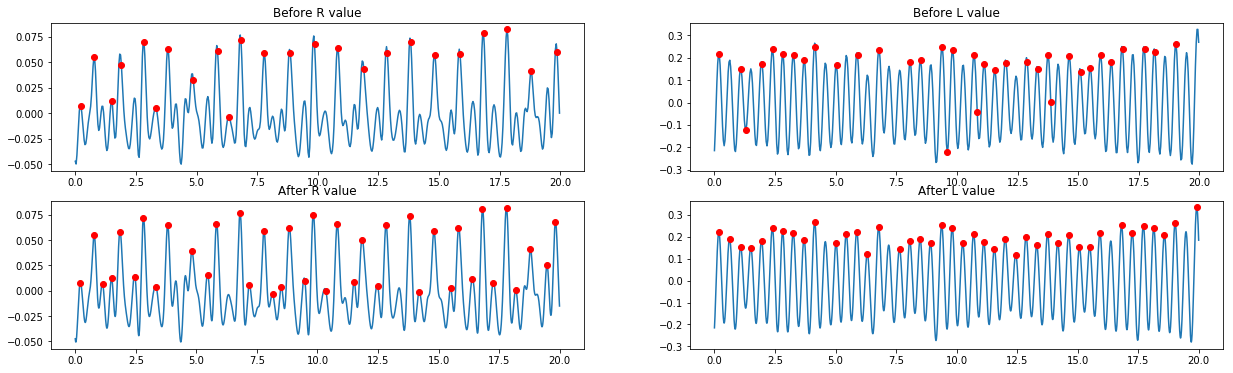

./video/sy_2.MOV is being handled
Video Load done. Frame shape : %s (2459, 1920, 1080, 3)
Filtering Done
Before (R) : %s 57
Before (L) : %s 54
After (R) : %s 57
After (L) : %s 66


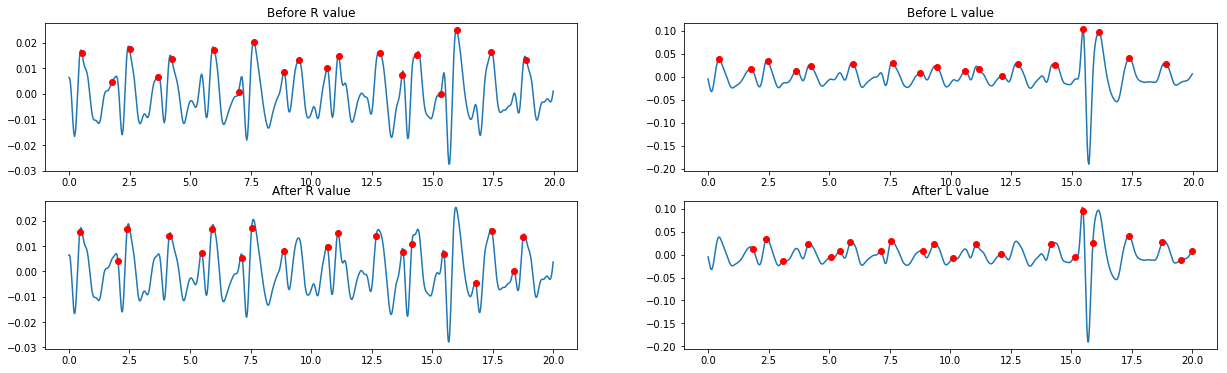

./video/sy_1.MOV is being handled
Video Load done. Frame shape : %s (1220, 1920, 1080, 3)
Filtering Done
Before (R) : %s 78
Before (L) : %s 75
After (R) : %s 81
After (L) : %s 63


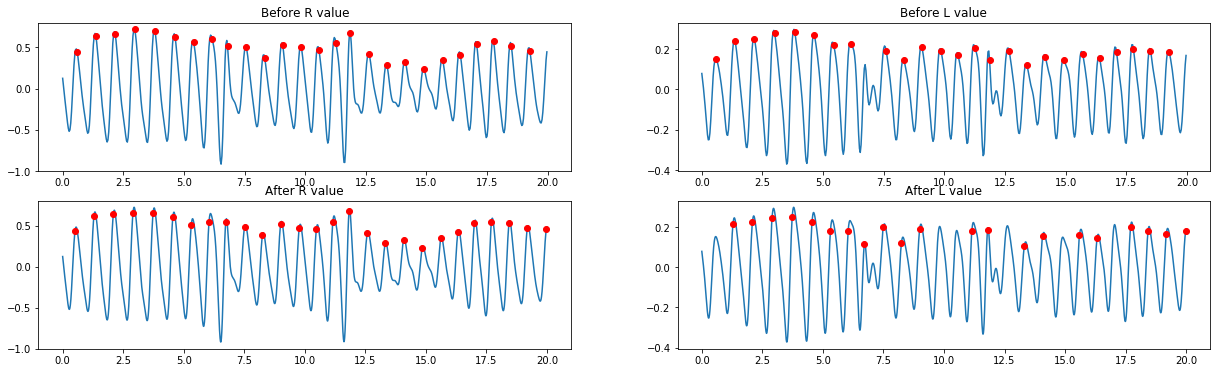

./video/ys_2.mov is being handled
Video Load done. Frame shape : %s (1338, 1920, 1080, 3)
Filtering Done
Before (R) : %s 75
Before (L) : %s 78
After (R) : %s 72
After (L) : %s 60


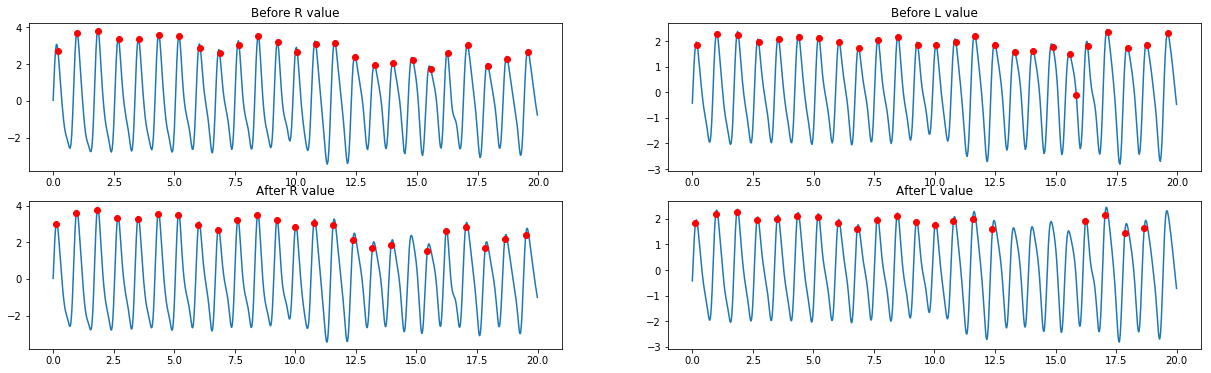

./video/ys_1.MOV is being handled
Video Load done. Frame shape : %s (1365, 1920, 1080, 3)
Filtering Done
Before (R) : %s 78
Before (L) : %s 75
After (R) : %s 69
After (L) : %s 54


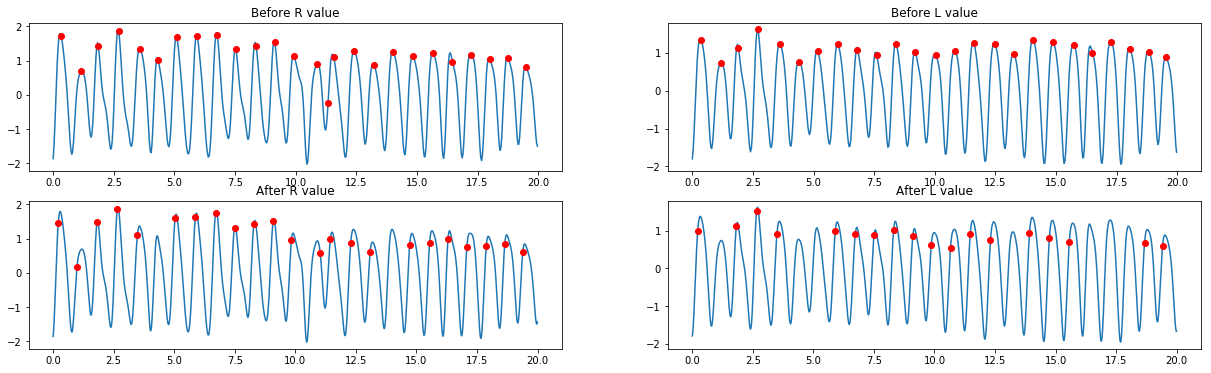

In [100]:
import os
dirpath = './video/'
files = os.listdir(dirpath)
for file in files:
    if file.split('.')[-1].lower()=='mov':
        filepath = dirpath+file
        calBps(filepath)

## 8. Comment

In our analysis, there is no ultimate well-done way to measure heartbeat-rate.
For sy, R value is unstable(specially first 2 videos) and more for exercise state.
More unstable, Filtering + Luminance result is most accurate.
However, for ys, she has stable video state and just moving average of R value looks accurate.

Our Results is
1. By body state and camera environment, the best heart-rate detection algorithm is changing.
    * More unstable -> L value + Interpolate is best
2. Peak Detection Algorithm is not accurate.
    * brute-force to get the width.. 
3. L value is more accurate than R value.
4. We used band-pass filtering method, so finding peak by using slope is more accurate in here.

---
## Apendix

### Using slope to find peak (Example)

In [116]:
def findPeak(data):
    befdata = -100
    befidx = -1
    up=True
    down=False
    slopeidx=[]
    for idx, da in enumerate(data):
        if up:
            if befdata>da:
                if da>0:
                    # It should be bigger than 0
                    slopeidx.append(idx)
        if befdata<da:
            up=True
            down=False
        else:
            up=False
            down=True
        befdata = da
    return slopeidx

81


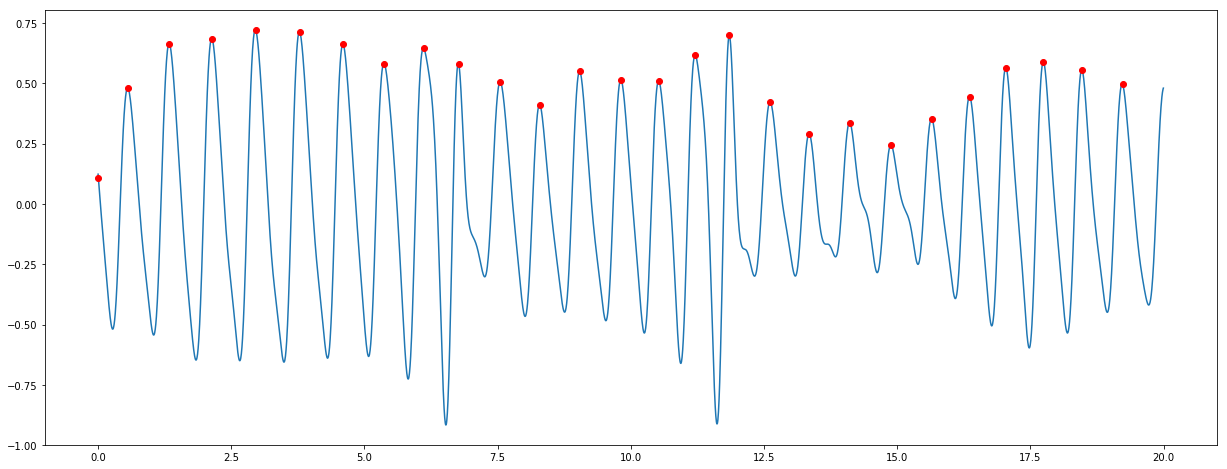

In [118]:

fs = 180 # unsampled Hz
# time vector (first 20s)
t = np.arange(0,20,1/fs)

fig = plt.figure(figsize=(21, 8))

# Use findPeak Module to find peak
peakind = findPeak(interpolate_r[:len(t)])
plt.plot(t, interpolate_r[:len(t)])
plt.plot(t[peakind],interpolate_r[peakind],'ro')

heart_beat = (len(peakind)*3)
print (heart_beat)